# Monthly traffic on English Wikipedia January 2008 - August 2020

The purpose of this notebook is to implement a analysis project that is fully reproducible by others. The goal of this notebook is to construct and analyze a dataset of monthly traffic on English Wikipedia from January 2008 to August 2020. 

## Table of Content

1. [Gathering the data](#Gathering-the-data) <br>
2. [Processing the data](#Processing-the-data) <br>
3. [Analyze the data](#Analyze-the-data)

## Gathering the data

### Import useful packages, establish API endpoints, and specify parameters

In [145]:
import json
import csv
import requests
import pandas as pd
import datetime
from functools import reduce 
%matplotlib inline
import matplotlib.pyplot as plt

endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/{access-site}/monthly/2008010100/2016080100'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/{access}/{agent}/monthly/2015070100/2020090100'

# can adjust the parameters accordingly
params_pagecounts_desktop = {"access-site" : "desktop-site"}
params_pagecounts_mobile = {"access-site" : "mobile-site"}
params_pageviews_desktop = {"access" : "desktop", "agent" : "user"}
params_pageviews_mobileapp = {"access" : "mobile-app", "agent" : "user"}
params_pageviews_mobileweb = {"access" : "mobile-web", "agent" : "user"}

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/mabelli',
    'From': 'yunhongl@uw.edu'
}

### Retrieve corresponding data

In [3]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

pagecounts_desktop = api_call(endpoint_pagecounts, params_pagecounts_desktop)
pagecounts_mobile = api_call(endpoint_pagecounts, params_pagecounts_mobile)
pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)
pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)

### Store data into five json files

In [7]:
def save_json_file(data, apiname, accesstype, startmonth, endmonth):
    params = {"apiname" : apiname, "accesstype" : accesstype, "startmonth" : startmonth, "endmonth": endmonth}
    filename = '{apiname}_{accesstype}_{startmonth}-{endmonth}.json'
    
    with open(filename.format(**params), 'w') as outfile:
        json.dump(pagecounts_desktop, outfile)
    

save_json_file(pagecounts_desktop, "pagecounts", "desktop-site", "200801", "201607")
save_json_file(pagecounts_mobile, "pagecounts", "mobile-site", "200801", "201607")
save_json_file(pageviews_desktop, "pageviews", "desktop", "201507", "202008")
save_json_file(pageviews_mobileapp, "pageviews", "mobile-app", "201507", "202008")
save_json_file(pageviews_mobileweb, "pageviews", "mobile-web", "201507", "202008")

## Processing the data

### Convert data to pandas dataframe

In [85]:
pagecounts_desktop_df = pd.DataFrame.from_dict(pagecounts_desktop['items'])
pagecounts_mobile_df = pd.DataFrame.from_dict(pagecounts_mobile['items'])
pageviews_desktop_df = pd.DataFrame.from_dict(pageviews_desktop['items'])
pageviews_mobileapp_df = pd.DataFrame.from_dict(pageviews_mobileapp['items'])
pageviews_mobileweb_df = pd.DataFrame.from_dict(pageviews_mobileweb['items'])

### Drop unwanted columns and rename counts/views column

In [ ]:
def drop_rename_columns(df, accesstype):
    df_drop = df.drop(['access-site', 'access', 'granularity', 'project', 'agent'], axis = 1, errors = 'ignore')
    if 'count' in df_drop.columns:
        name = "pagecount_{accessType}_views".format(accessType = accesstype)
        df_drop = df_drop.rename(columns={"count": name})
    else:
        name = "pageview_{accessType}_views".format(accessType = accesstype)
        df_drop = df_drop.rename(columns={"views": name})
    
    return df_drop

pagecounts_desktop_processed = drop_rename_columns(pagecounts_desktop_df, "desktop")
pagecounts_mobile_processed = drop_rename_columns(pagecounts_mobile_df, "mobile")
pageviews_desktop_processed = drop_rename_columns(pageviews_desktop_df, "desktop")
pageviews_mobileapp_processed = drop_rename_columns(pageviews_mobileapp_df, "mobileapp")
pageviews_mobileweb_processed = drop_rename_columns(pageviews_mobileweb_df, "mobileweb")

### Merge all dataframes into one dataframe using the timestamp column as key and fill missing data with zeros

In [125]:
def merge_two_df(df1, df2):
    return df1.merge(df2, on = 'timestamp', how='outer')

merged_df = reduce(merge_two_df, [pagecounts_desktop_processed, pagecounts_mobile_processed, pageviews_desktop_processed, pageviews_mobileapp_processed, pageviews_mobileweb_processed])
    
merged_df.fillna(0, inplace=True)

### Create summary columns for pagecount and pageview, and convert timestamp column into year and month

In [133]:
merged_df['pagecount_all_views'] = merged_df.pagecount_desktop_views + merged_df.pagecount_mobile_views
merged_df['pageview_mobile_views'] = merged_df.pageview_mobileapp_views + merged_df.pageview_mobileweb_views
merged_df['pageview_all_views'] = merged_df.pageview_mobile_views + merged_df.pageview_desktop_views

merged_df['year'] = merged_df.timestamp.map(lambda timestamp: timestamp[:4])
merged_df['month'] = merged_df.timestamp.map(lambda timestamp: timestamp[4:6])
# another approach: convert to datetime format, convert to string, and fill missing digits for months
# pd.to_datetime(pagecounts_desktop_df.timestamp, format="%Y%m%d%H").map(lambda x: f'{x.month:02}')

final_df = merged_df.drop(['timestamp', 'pageview_mobileapp_views', 'pageview_mobileweb_views'], axis =1)

### Save the final dataframe to a csv

In [146]:
with open("en-wikipedia_traffic_200712-202008.csv", 'w') as outputfile:
    final_df.to_csv(outputfile, index = False)

## Analyze the data

### Remove zero datapoints as we do not want to plot them in the graph

In [152]:
df_for_visualization = final_df.replace(to_replace = 0, value = pd.np.nan)

### Create a datetime column for plotting

In [156]:
df_for_visualization['month_year'] = df_for_visualization.year + df_for_visualization.month
df_for_visualization['month_year_converted'] = pd.to_datetime(df_for_visualization.month_year, format="%Y%m")

### Visualization of time versus different pageview traffic and save the figure

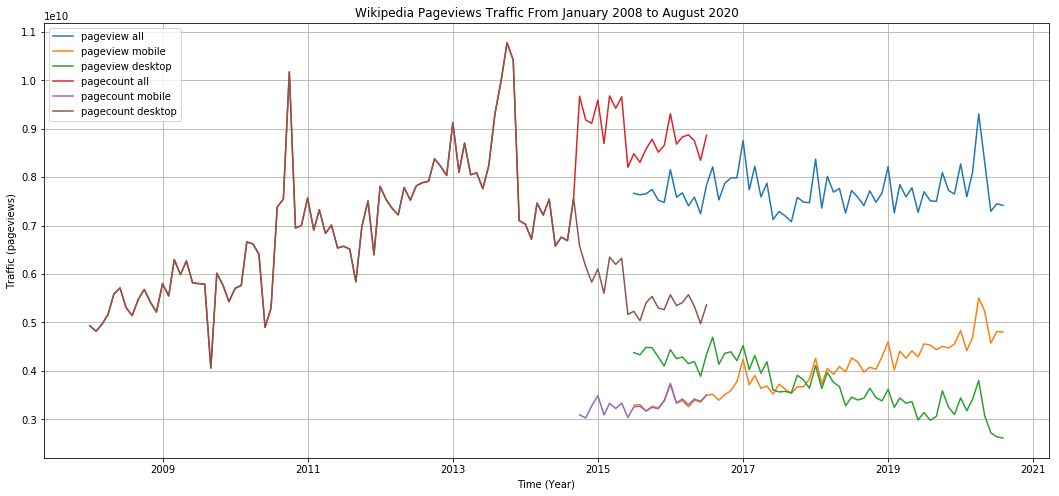

In [162]:
plt.figure(figsize=(18, 8))

plt.plot(df_for_visualization.month_year_converted, df_for_visualization.pageview_all_views)
plt.plot(df_for_visualization.month_year_converted, df_for_visualization.pageview_mobile_views)
plt.plot(df_for_visualization.month_year_converted, df_for_visualization.pageview_desktop_views)

plt.plot(df_for_visualization.month_year_converted, df_for_visualization.pagecount_all_views)
plt.plot(df_for_visualization.month_year_converted, df_for_visualization.pagecount_mobile_views)
plt.plot(df_for_visualization.month_year_converted, df_for_visualization.pagecount_desktop_views)

#ymin, ymax = plt.ylim()

plt.legend(["pageview all", "pageview mobile", "pageview desktop", "pagecount all", "pagecount mobile", "pagecount desktop"])

plt.xlabel("Time (Year)")
plt.ylabel("Traffic (pageviews)")

plt.title("Wikipedia Pageviews Traffic From January 2008 to August 2020")
plt.grid()

plt.savefig('visualization.jpeg')